In [1]:
import gzip, pickle
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch.nn import functional as F
import nibabel as nib
from neurovlm.data import data_dir
from neurovlm.models import Specter
from neurovlm.retrieval_resources import (
    _load_autoencoder, _proj_head_image_infonce, _proj_head_text_infonce, _load_masker
)

In [2]:
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query", device="cuda")
proj_head_text = _proj_head_text_infonce().to("cuda")
proj_head_image = _proj_head_image_infonce().to("cuda")
autoencoder = _load_autoencoder().to("cuda")
masker = _load_masker()

There are adapters available but none are activated for the forward pass.


In [4]:
# Load network atlases
with gzip.open(data_dir / "networks_arrays.pkl.gz", "rb") as f:
    networks = pickle.load(f)

network_imgs = []
for k in networks.keys():
    for a in networks[k].keys():
        network_imgs.append((k, a, nib.Nifti1Image(networks[k][a]["array"], affine=networks[k][a]["affine"])))

networks = [i for i in network_imgs if i[0] in ["UKBICA", "HCPICA"]]

networks_embed = F.normalize(proj_head_image(torch.load(data_dir / "networks_emb.pt").to("cuda")).detach(), dim=1)

In [ ]:
# labels = np.load(data_dir / "ngram_labels.npy")
# nets = [i for i in labels if "network" in i.lower()]
# nets = [
#     'frontoparietal network', 'language network', 'memory network', 'motor network', 'action-observation network',
#     'reward network', 'semantic network', 'sensorimotor network', "visual network",  "central executive network",
#     "cognitive control network", "deault mode network", "executive control network", "salience network",
#     "attention network", "ventral attention network", "dorsal attention network"
# ]

nets = {
    "frontoparietal": (
        "A domain-general control network supporting flexible, goal-directed behavior (task set maintenance, rule switching, "
        "working-memory control, adaptive decision-making). Neuroanatomically centered on dorsolateral prefrontal cortex "
        "(middle frontal gyrus), inferior/superior parietal lobule and intraparietal sulcus, with contributions from dorsal "
        "premotor areas and midline control regions."
    ),
    "language": (
        "A left-lateralized network for speech perception/production and sentence-level comprehension (phonology, syntax, "
        "semantics, speech planning). Typically includes inferior frontal gyrus (Broca’s area: pars opercularis/triangularis), "
        "posterior superior temporal gyrus/sulcus, middle temporal gyrus, anterior temporal lobe, and angular gyrus, with white-matter "
        "support via arcuate/superior longitudinal fasciculus."
    ),
    "memory": (
        "A network supporting episodic memory encoding and retrieval (scene/context construction, recollection, consolidation). "
        "Anchored in the medial temporal lobe (hippocampus, parahippocampal/entorhinal cortex) and strongly coupled to posterior "
        "cingulate/precuneus, retrosplenial cortex, medial prefrontal cortex, and lateral parietal cortex."
    ),
    "motor": (
        "A network for planning, initiation, and execution of voluntary movements (motor sequencing, force control). Core nodes "
        "include primary motor cortex (precentral gyrus), supplementary motor area/pre-SMA, dorsal premotor cortex, with subcortical "
        "loops through basal ganglia and cerebellum."
    ),
    "action-observation": (
        "Often overlapping with the ‘mirror’ system, this network supports action understanding, imitation, and mapping observed actions "
        "to motor representations. Involves inferior frontal gyrus/ventral premotor cortex, inferior parietal lobule (supramarginal/angular), "
        "and posterior superior temporal sulcus as a key visual–biological motion hub."
    ),
    "reward": (
        "A network supporting valuation, reinforcement learning, and motivated behavior (prediction error, incentive salience, reward-guided choice). "
        "Includes ventral striatum/nucleus accumbens, ventromedial/orbitofrontal cortex, anterior cingulate cortex, amygdala, hippocampus, and midbrain "
        "dopaminergic regions (VTA/substantia nigra) with thalamic interactions."
    ),
    "semantic": (
        "A network for conceptual knowledge and meaning integration across modalities (word meaning, category knowledge, semantic control). "
        "Often includes anterior temporal lobe (semantic hub), middle/inferior temporal gyrus, angular gyrus, posterior superior temporal cortex, "
        "and inferior frontal gyrus for controlled semantic retrieval/selection."
    ),
    "sensorimotor": (
        "A network integrating somatosensory input with motor output (tactile perception, proprioception, sensorimotor coordination). "
        "Centered on precentral and postcentral gyri, paracentral lobule, SMA, and secondary somatosensory cortex (parietal operculum), "
        "with contributions from insula and cerebellum for integration and timing."
    ),
    "visual": (
        "A set of occipital and occipito-temporal systems supporting visual perception (low-level feature processing through higher-level object/scene processing). "
        "Includes primary visual cortex (calcarine sulcus/V1), extrastriate areas (V2–V5/MT), lateral occipital cortex, fusiform gyrus, and parahippocampal "
        "place area for scenes, often extending into intraparietal regions for visuospatial processing."
    ),
    "central executive": (
        "A classic control network for working memory, sustained attention, and top-down regulation of thought/action. Neuroanatomically overlaps strongly "
        "with frontoparietal control systems, emphasizing dorsolateral prefrontal cortex and posterior parietal cortex (IPS/SPL), with coordination via dorsal "
        "ACC/pre-SMA in demanding tasks."
    ),
    "cognitive control": (
        "A network implementing top-down control over perception and action (conflict monitoring, inhibition, rule implementation, error processing). "
        "Typically spans dorsolateral and ventrolateral prefrontal cortex, dorsal anterior cingulate cortex/pre-SMA, and posterior parietal cortex, "
        "with basal ganglia contributions for gating and action selection."
    ),
    "default mode": (
        "The default mode network supports internally oriented cognition (mind-wandering, autobiographical memory, self-referential thought, future simulation, "
        "social cognition). Core hubs include posterior cingulate cortex/precuneus and medial prefrontal cortex, with lateral parietal cortex (angular gyrus) "
        "and medial temporal lobe coupling (hippocampus/parahippocampal) depending on memory demands."
    ),
    "executive control": (
        "A network for executive functions like planning, set shifting, maintaining goals, and suppressing distractions. Neuroanatomically overlaps with "
        "frontoparietal/central executive systems (dlPFC and posterior parietal), often coordinating with dorsal ACC/pre-SMA for performance monitoring "
        "and with basal ganglia for action/response selection."
    ),
    "salience": (
        "A network that detects behaviorally relevant stimuli and coordinates switching between internal (DMN) and externally oriented control/attention systems "
        "(rapid orienting, interoception, threat detection). Anchored in anterior insula (especially right), dorsal anterior cingulate cortex, and subcortical "
        "nodes including amygdala, thalamus, and periaqueductal/midbrain regions."
    ),
    "attention": (
        "A broad term for systems supporting selective attention and attentional control (orienting, prioritizing sensory inputs, maintaining vigilance). "
        "Typically spans frontoparietal regions—frontal eye fields, intraparietal sulcus/superior parietal lobule—and interacts with ventral fronto-insular "
        "and temporoparietal regions depending on goal-driven vs. stimulus-driven demands."
    ),
    "ventral attention": (
        "A right-lateralized network for stimulus-driven reorienting to salient or unexpected events (circuit breaker for attention, target detection). "
        "Key nodes include temporoparietal junction, ventral frontal cortex (inferior/middle frontal gyrus), and anterior insula, interacting with sensory "
        "cortex to shift attention rapidly."
    ),
    "dorsal attention": (
        "A bilateral network for goal-directed, top-down allocation of attention (spatial orienting, sustained visuospatial attention, saccade planning). "
        "Centered on intraparietal sulcus/superior parietal lobule and frontal eye fields, with contributions from dorsal premotor regions and visual cortex "
        "for prioritized processing."
    )
}

text = [i + " [SEP] " + nets[i] for i in nets.keys()]
nets = list(nets.keys())


In [285]:
with torch.no_grad():
    labels_emb =  F.normalize(specter(text), dim=1)
    labels_emb = F.normalize(proj_head_text(labels_emb), dim=1)

In [ ]:
hcp_networks_orig = [
    i[2] for i in networks if i[0] == "HCPICA"
]

uk_networks_orig = [
    i[2] for i in networks if i[0] == "UKBICA"
]

hcp_networks = [
    masker.transform(i[2]) for i in networks if i[0] == "HCPICA"
]

hcp_networks = np.array(hcp_networks)

uk_networks = [
    masker.transform(i[2]) for i in networks if i[0] == "UKBICA"
]

uk_networks = np.array(uk_networks)
uk_networks = uk_networks[:, 0]

[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/home/rph/neurovlm/.env/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


In [8]:
from nilearn.plotting import view_img

In [296]:
thresh = 0.1

with torch.no_grad():
    hcp_emb = F.normalize(proj_head_image(
        autoencoder.encoder(torch.from_numpy((np.abs(hcp_networks) > thresh).astype(np.float32)).to("cuda"))
    ), dim=1)
    uk_emb = F.normalize(proj_head_image(
        autoencoder.encoder(torch.from_numpy((np.abs(uk_networks) > thresh).astype(np.float32)).to("cuda"))
    ), dim=1)

In [318]:
hcp_cos = hcp_emb @ labels_emb.T
uk_cos = uk_emb @ labels_emb.T

nets = np.array(nets)

In [ ]:
def bars(results, lab, i_ax=1):

    i = 0

    for ax, r in zip(axes[:, i_ax], results):
        _labels = [i.split(" (")[0] for i in r[1]]
        _sim = r[2]
        _sim[_sim < 0] = 0.

        # Create color palette based on values
        colors = ['red' if val < 0 else 'steelblue' for val in _sim]
        y_vals = range(0, len(_sim))

        sns.barplot(y=y_vals, x=_sim, orient="h", ax=ax,
                    hue=y_vals, palette=colors, alpha=0.8, legend=False)

        for patch, _label in zip(ax.patches, _labels):
            y0 = patch.get_y()
            h = patch.get_height()
            y_top = y0 + h
            ax.annotate(
                _label,
                (0.01, y_top-.1),
                xytext=(0, 0),
                textcoords="offset points",
                ha="left",
                va="bottom",
                fontsize=9,
            )
        if i == 0:
             ax.spines[['bottom', 'right', 'left']].set_visible(False)
             ax.yaxis.set_visible(False)
             ax.xaxis.set_visible(False)
             ax.set_title(lab)
        elif i < 7:
            ax.axis("off")
        else:
            ax.spines[['top', 'right', 'left']].set_visible(False)
            ax.yaxis.set_visible(False)
            ax.set_xlabel("Cosine Similarity")  # Changed from set_ylabel

        ax.set_xlim(0, 0.5)
        i += 1

In [ ]:
inds_networks = hcp_cos.argsort(dim=1, descending=True).cpu()
results_networks = [(networks[idx][1], nets[i[:5]], hcp_cos.cpu().numpy()[idx, i[:5]], networks[idx][2]) for idx, i in enumerate(inds_networks.numpy())]

m = {}
for idx, i in enumerate(inds_networks):
    s = hcp_cos[idx, i[0]]
    if nets[i[0]] not in m.keys():
        m[nets[i[0]]] = (idx, s)
    elif s > m[nets[i[0]]][1]:
        m[nets[i[0]]] = (idx, s)

results_networks = [results_networks[v[0]] for v in m.values()]
imgs = [i[-1] for i in results_networks]

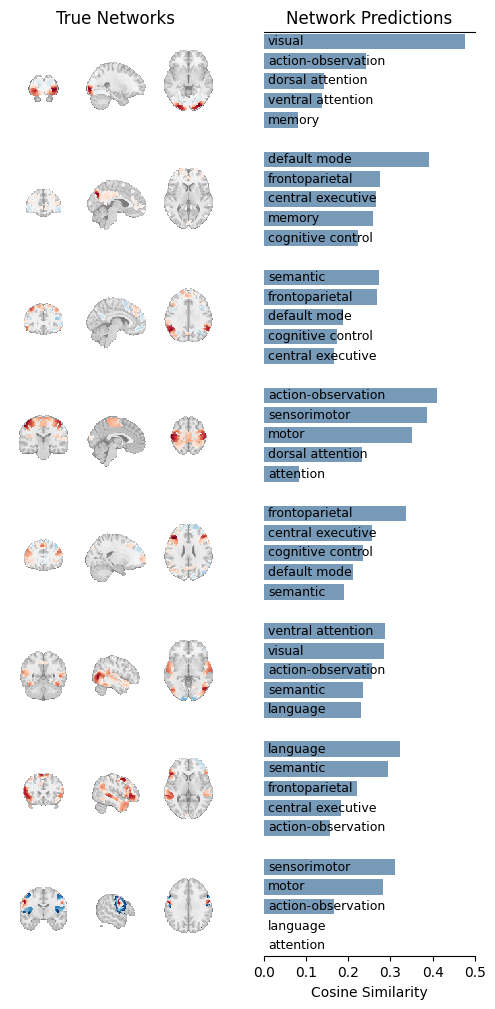

In [321]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(6, 12), sharex="col")

# Barplots
bars([i for idx, i in enumerate(results_networks)], "Network Predictions", i_ax=1)
# bars([i for idx, i in enumerate(results_regions) if idx in df.index.values], "Region Predictions", i_ax=2)
# bars([i for idx, i in enumerate(results_cognition) if idx in df.index.values], "Cognition Predictions", i_ax=3)

# Network images
imgs = [i[-1] for i in results_networks]

first = True
for ax, img in zip(axes[:, 0], imgs):

    plot_stat_map(img, colorbar=False, draw_cross=False, annotate=False, axes=ax)

    ax.set_yticks([])
    ax.set_xticks([])

    if first:
        ax.set_title("True Networks")
    first = False

plt.savefig(data_dir / "clip_ica_hcp.svg", dpi=300)

In [ ]:
inds_networks = uk_cos.argsort(dim=1, descending=True).cpu()
results_networks = [(networks[20:][idx][1], nets[i[:5]], uk_cos.cpu().numpy()[idx, i[:5]], networks[20:][idx][2])
                    for idx, i in enumerate(inds_networks.numpy())]

m = {}
for idx, i in enumerate(inds_networks):
    s = uk_cos[idx, i[0]]
    if nets[i[0]] not in m.keys():
        m[nets[i[0]]] = (idx, s)
    elif s > m[nets[i[0]]][1]:
        m[nets[i[0]]] = (idx, s)

results_networks = [results_networks[v[0]] for v in m.values()]
imgs = [i[-1] for i in results_networks]

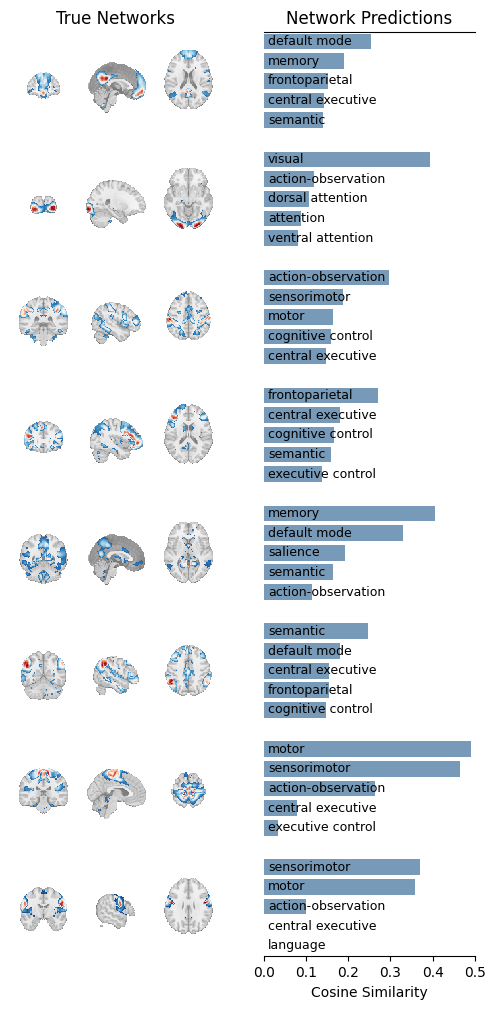

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(6, 12), sharex="col")

# Barplots
bars([i for idx, i in enumerate(results_networks)], "Network Predictions", i_ax=1)
# bars([i for idx, i in enumerate(results_regions) if idx in df.index.values], "Region Predictions", i_ax=2)
# bars([i for idx, i in enumerate(results_cognition) if idx in df.index.values], "Cognition Predictions", i_ax=3)

# Network images
imgs = [i[-1] for i in results_networks]

first = True
for ax, img in zip(axes[:, 0], imgs):

    plot_stat_map(img, colorbar=False, draw_cross=False, annotate=False, axes=ax)

    ax.set_yticks([])
    ax.set_xticks([])

    if first:
        ax.set_title("True Networks")
    first = False


plt.savefig(data_dir / "clip_ica_ukb.svg", dpi=300)